Iter 0: Loss Dipole 419.2431 | Loss Std 1413.7167
Iter 1000: Loss Dipole 0.0673 | Loss Std 0.2310
Iter 2000: Loss Dipole 0.0353 | Loss Std 0.1210
Iter 3000: Loss Dipole 0.0244 | Loss Std 0.0588
Iter 4000: Loss Dipole 0.0218 | Loss Std 0.0525
Iter 5000: Loss Dipole 0.0191 | Loss Std 0.0518
Iter 6000: Loss Dipole 0.0163 | Loss Std 0.0509
Iter 7000: Loss Dipole 0.0144 | Loss Std 0.0498
Iter 8000: Loss Dipole 0.0205 | Loss Std 0.0484
Iter 9000: Loss Dipole 0.0128 | Loss Std 0.0468
Iter 10000: Loss Dipole 0.0130 | Loss Std 0.0454
Iter 11000: Loss Dipole 0.0124 | Loss Std 0.0449
Iter 12000: Loss Dipole 0.0117 | Loss Std 0.0447
Iter 13000: Loss Dipole 0.0115 | Loss Std 0.0445
Iter 14000: Loss Dipole 0.0112 | Loss Std 0.0452
Iter 15000: Loss Dipole 0.0110 | Loss Std 0.0447
Iter 16000: Loss Dipole 0.0183 | Loss Std 0.0445
Iter 17000: Loss Dipole 0.0107 | Loss Std 0.0452
Iter 18000: Loss Dipole 0.0138 | Loss Std 0.0442
Iter 19000: Loss Dipole 0.0104 | Loss Std 0.0442
Iter 20000: Loss Dipole 0.01

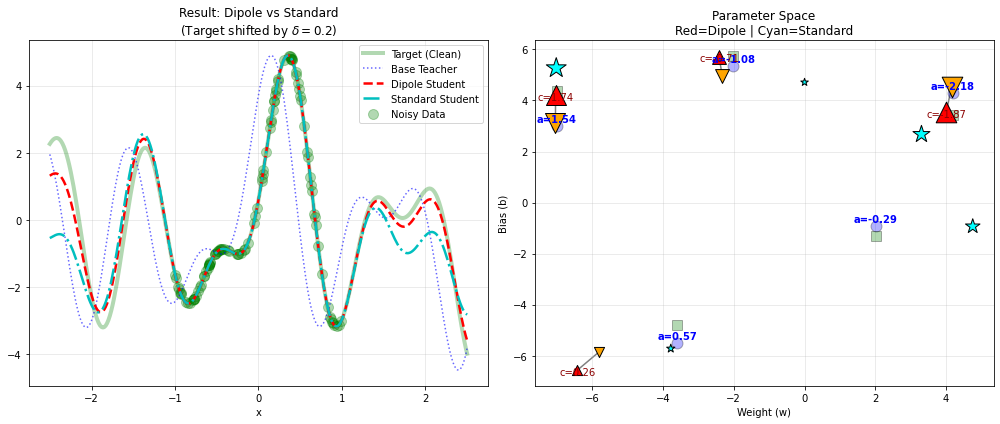

In [26]:
### Activation function: sin ###

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Configuration ---
torch.manual_seed(0) 
N_TEACHER = 5          
M_CORRECTION = 5       
delta = 0.2            
n_data = 100           
iterations = 50000
learning_rate = 0.01   # Constant Learning Rate

# Noise level
noise_level = 0

# Filter threshold for plotting
c_threshold = 0.0001

# Hyperparameters for Dipole Student
alpha = 0.01       
beta = 0.00001      

# Hyperparameters for Standard Student
alpha_tv = 0.01    

# --- 1. Define Teacher & Shifted Teacher ---
a_teacher = torch.randn(N_TEACHER)
w_teacher = 5 * torch.randn(N_TEACHER)
b_teacher = -5 * torch.randn(N_TEACHER)

# Shifted Teacher (Target)
w_shifted = w_teacher.clone()
b_shifted = b_teacher - w_teacher * delta
a_shifted = a_teacher.clone()

# --- 2. Define Network Parameters ---

# A. DIPOLE STUDENT
w_plus = w_teacher.clone().detach().requires_grad_(True)
b_plus = b_teacher.clone().detach().requires_grad_(True)
w_minus = w_teacher.clone().detach().requires_grad_(True)
b_minus = b_teacher.clone().detach().requires_grad_(True)
c = a_teacher.clone().detach().requires_grad_(True)

# B. STANDARD STUDENT
w_bar = w_teacher.clone().detach().requires_grad_(True)
b_bar = b_teacher.clone().detach().requires_grad_(True)
a_bar = a_teacher.clone().detach().requires_grad_(True)

# --- SPLIT OPTIMIZERS ---
optimizer_dipole = optim.Adam([c, w_plus, b_plus, w_minus, b_minus], lr=learning_rate)
optimizer_standard = optim.Adam([w_bar, b_bar, a_bar], lr=learning_rate)

def sigma(x):
    return torch.sin(x)

# --- Pre-calculate Validation Data (Range [-2.5, 2.5]) ---
x_val = torch.linspace(-2.5, 2.5, 300)
y_target_val = torch.zeros_like(x_val)
y_base_val = torch.zeros_like(x_val)

with torch.no_grad():
    for i in range(N_TEACHER):
        y_target_val += a_shifted[i] * sigma(w_shifted[i] * x_val + b_shifted[i])
        y_base_val += a_teacher[i] * sigma(w_teacher[i] * x_val + b_teacher[i])

# --- 3. Training Loop ---
# Storage for metrics (calculated but not plotted)
val_mse_history_dipole = []
val_mse_history_standard = []

x_final_batch = None
y_target_final_batch = None

# Training Data (Random batch in [-1, 1] - Fixed once)
x = (torch.rand(n_data) * 2) - 1 

# Generate Training Targets 
y_target_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_target_train += a_shifted[i] * sigma(w_shifted[i] * x + b_shifted[i])
    
if noise_level > 0:
    noise = torch.randn(n_data) * noise_level
    y_target_train = y_target_train + noise

# Base Teacher Output on Training Data
y_base_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_base_train += a_teacher[i] * sigma(w_teacher[i] * x + b_teacher[i])

for it in range(iterations):

    # ==========================
    # 1. OPTIMIZE DIPOLE STUDENT
    # ==========================
    optimizer_dipole.zero_grad()
    
    # Forward
    y_dipole_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        term_plus = sigma(w_plus[i] * x + b_plus[i])
        term_minus = sigma(w_minus[i] * x + b_minus[i])
        y_dipole_train += c[i] * (term_plus - term_minus)

    # Loss Calculation
    loss_dipole_fit = torch.sum((y_dipole_train + y_base_train - y_target_train)**2)
    reg_alpha = 0
    reg_beta = 0
    for i in range(M_CORRECTION):
        dist = torch.sqrt((w_plus[i] - w_minus[i])**2 + (b_plus[i] - b_minus[i])**2 + 1e-8)
        reg_alpha += torch.abs(c[i]) * dist
        norm_plus = w_plus[i]**2 + b_plus[i]**2
        norm_minus = w_minus[i]**2 + b_minus[i]**2
        reg_beta += torch.abs(c[i]) * (1 + norm_minus + norm_plus)
    total_loss_dipole = loss_dipole_fit + (alpha * reg_alpha / M_CORRECTION) + (beta * reg_beta / M_CORRECTION)
    
    total_loss_dipole.backward()
    optimizer_dipole.step()

    # ============================
    # 2. OPTIMIZE STANDARD STUDENT
    # ============================
    optimizer_standard.zero_grad()

    # Forward
    y_standard_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        y_standard_train += a_bar[i] * sigma(w_bar[i] * x + b_bar[i])

    # Loss Calculation
    loss_standard_fit = torch.sum((y_standard_train + y_base_train - y_target_train)**2)
    reg_tv = alpha_tv * torch.sum(torch.abs(a_bar))
    total_loss_standard = loss_standard_fit + reg_tv

    total_loss_standard.backward()
    optimizer_standard.step()

    # --- Validation / MSE Tracking (Every 100 steps) ---
    if it % 100 == 0:
        with torch.no_grad():
            # Dipole Validation
            y_d_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_d_val += c[i] * (sigma(w_plus[i] * x_val + b_plus[i]) - sigma(w_minus[i] * x_val + b_minus[i]))
            
            # Standard Validation
            y_s_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_s_val += a_bar[i] * sigma(w_bar[i] * x_val + b_bar[i])
            
            # Compute MSE on big range
            mse_d = torch.mean((y_d_val + y_base_val - y_target_val)**2).item()
            mse_s = torch.mean((y_s_val + y_base_val - y_target_val)**2).item()
            
            val_mse_history_dipole.append(mse_d)
            val_mse_history_standard.append(mse_s)

    if it % 1000 == 0:
        print(f"Iter {it}: Loss Dipole {total_loss_dipole.item():.4f} | Loss Std {total_loss_standard.item():.4f}")

    if it == iterations - 1:
        x_final_batch = x.detach().numpy()
        y_target_final_batch = y_target_train.detach().numpy()

# --- 4. Visualization ---

plt.figure(figsize=(14, 6)) 

# --- Plot 1: Functions ---
plt.subplot(1, 2, 1)
plt.title(f"Result: Dipole vs Standard\n(Target shifted by $\delta={delta}$)")
plt.scatter(x_final_batch, y_target_final_batch, c='green', alpha=0.3, s=100, label='Noisy Data')
plt.plot(x_val, y_target_val, 'g-', linewidth=4, alpha=0.3, label='Target (Clean)')
plt.plot(x_val, y_base_val, 'b:', linewidth=1.5, alpha=0.6, label='Base Teacher')

plt.plot(x_val, y_base_val + y_d_val, 'r--', linewidth=2.5, label='Dipole Student')
plt.plot(x_val, y_base_val + y_s_val, 'c-.', linewidth=2.5, label='Standard Student')

plt.legend()
plt.grid(True, alpha=0.3)
plt.xlabel("x")

# --- Plot 2: Parameter Space ---
plt.subplot(1, 2, 2)
plt.title(f"Parameter Space\nRed=Dipole | Cyan=Standard")
plt.scatter(w_teacher, b_teacher, c='blue', s=120, label='Base Teacher', marker='o', edgecolors='k', zorder=2, alpha=0.3)
plt.scatter(w_shifted, b_shifted, c='green', s=120, label='Target', marker='s', edgecolors='k', zorder=2, alpha=0.3)

wp = w_plus.detach().numpy()
bp = b_plus.detach().numpy()
wm = w_minus.detach().numpy()
bm = b_minus.detach().numpy()
c_vals = c.detach().numpy()
c_sizes = np.abs(c_vals) * 200 + 50 

for i in range(M_CORRECTION):
    plt.text(w_teacher[i], b_teacher[i] + 0.15, f"a={a_teacher[i]:.2f}", 
             color='blue', fontsize=10, ha='center', fontweight='bold')
    if abs(c_vals[i]) > c_threshold:
        plt.scatter(wp[i], bp[i], c='red', s=c_sizes[i], marker='^', edgecolors='k', zorder=3)
        plt.scatter(wm[i], bm[i], c='orange', s=c_sizes[i], marker='v', edgecolors='k', zorder=3)
        plt.plot([wp[i], wm[i]], [bp[i], bm[i]], 'k-', alpha=0.5, zorder=1)
        plt.text(wp[i], bp[i] - 0.2, f"c={c_vals[i]:.2f}", color='darkred', fontsize=10, ha='center')

wb = w_bar.detach().numpy()
bb = b_bar.detach().numpy()
ab = a_bar.detach().numpy() / M_CORRECTION 
ab_sizes = np.abs(ab) * 1000 + 50 
plt.scatter(wb, bb, c='cyan', s=ab_sizes, marker='*', label='Standard Student', edgecolors='k', zorder=4)
plt.xlabel("Weight (w)")
plt.ylabel("Bias (b)")
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save as PDF
plt.savefig("Train_sin_with_KR.pdf", format='pdf', bbox_inches='tight')
print("Plots saved to 'Train_sin_with_KR.pdf'")

# --- Quantitative Evaluation ---
print("\n" + "="*50)
print("FINAL ERROR EVALUATION (MSE on x in [-2.5, 2.5])")
print("="*50)
print(f"Dipole Student Error:   {val_mse_history_dipole[-1]:.8f}")
print(f"Standard Student Error: {val_mse_history_standard[-1]:.8f}")
print("="*50 + "\n")

plt.show()

In [ ]:
### Activation function: tanh ###

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Configuration ---
torch.manual_seed(0) 
N_TEACHER = 4          
M_CORRECTION = 4       
delta = 0.2            
n_data = 100           
iterations = 10000
learning_rate = 0.01   # Constant Learning Rate

# Noise level
noise_level = 0

# Filter threshold for plotting
c_threshold = 0.0001

# Hyperparameters for Dipole Student
alpha = 0.01       
beta = 0.00001      

# Hyperparameters for Standard Student
alpha_tv = 0.01    

# --- 1. Define Teacher & Shifted Teacher ---
a_teacher = torch.randn(N_TEACHER)
w_teacher = 5 * torch.randn(N_TEACHER)
b_teacher = -5 * torch.randn(N_TEACHER)

# Shifted Teacher (Target)
w_shifted = w_teacher.clone()
b_shifted = b_teacher - w_teacher * delta
a_shifted = a_teacher.clone()

# --- 2. Define Network Parameters ---

# A. DIPOLE STUDENT
w_plus = w_teacher.clone().detach().requires_grad_(True)
b_plus = b_teacher.clone().detach().requires_grad_(True)
w_minus = w_teacher.clone().detach().requires_grad_(True)
b_minus = b_teacher.clone().detach().requires_grad_(True)
c = a_teacher.clone().detach().requires_grad_(True)

# B. STANDARD STUDENT
w_bar = w_teacher.clone().detach().requires_grad_(True)
b_bar = b_teacher.clone().detach().requires_grad_(True)
a_bar = a_teacher.clone().detach().requires_grad_(True)

# --- SPLIT OPTIMIZERS ---
optimizer_dipole = optim.Adam([c, w_plus, b_plus, w_minus, b_minus], lr=learning_rate)
optimizer_standard = optim.Adam([w_bar, b_bar, a_bar], lr=learning_rate)

def sigma(x):
    return torch.tanh(x)

# --- Pre-calculate Validation Data (Range [-2.5, 2.5]) ---
x_val = torch.linspace(-2.5, 2.5, 300)
y_target_val = torch.zeros_like(x_val)
y_base_val = torch.zeros_like(x_val)

with torch.no_grad():
    for i in range(N_TEACHER):
        y_target_val += a_shifted[i] * sigma(w_shifted[i] * x_val + b_shifted[i])
        y_base_val += a_teacher[i] * sigma(w_teacher[i] * x_val + b_teacher[i])

# --- 3. Training Loop ---
# Storage for metrics (calculated but not plotted)
val_mse_history_dipole = []
val_mse_history_standard = []

x_final_batch = None
y_target_final_batch = None

# Training Data (Random batch in [-1, 1] - Fixed once)
x = (torch.rand(n_data) * 2) - 1 

# Generate Training Targets (Noise added every step)
y_target_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_target_train += a_shifted[i] * sigma(w_shifted[i] * x + b_shifted[i])
    
if noise_level > 0:
    noise = torch.randn(n_data) * noise_level
    y_target_train = y_target_train + noise
    
# Base Teacher Output on Training Data
y_base_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_base_train += a_teacher[i] * sigma(w_teacher[i] * x + b_teacher[i])

for it in range(iterations):

    # ==========================
    # 1. OPTIMIZE DIPOLE STUDENT
    # ==========================
    optimizer_dipole.zero_grad()
    
    # Forward
    y_dipole_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        term_plus = sigma(w_plus[i] * x + b_plus[i])
        term_minus = sigma(w_minus[i] * x + b_minus[i])
        y_dipole_train += c[i] * (term_plus - term_minus)

    # Loss Calculation
    loss_dipole_fit = torch.sum((y_dipole_train + y_base_train - y_target_train)**2)
    reg_alpha = 0
    reg_beta = 0
    for i in range(M_CORRECTION):
        dist = torch.sqrt((w_plus[i] - w_minus[i])**2 + (b_plus[i] - b_minus[i])**2 + 1e-8)
        reg_alpha += torch.abs(c[i]) * dist
        norm_plus = w_plus[i]**2 + b_plus[i]**2
        norm_minus = w_minus[i]**2 + b_minus[i]**2
        reg_beta += torch.abs(c[i]) * (1 + norm_minus + norm_plus)
    total_loss_dipole = loss_dipole_fit + (alpha * reg_alpha / M_CORRECTION) + (beta * reg_beta / M_CORRECTION)
    
    total_loss_dipole.backward()
    optimizer_dipole.step()

    # ============================
    # 2. OPTIMIZE STANDARD STUDENT
    # ============================
    optimizer_standard.zero_grad()

    # Forward
    y_standard_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        y_standard_train += a_bar[i] * sigma(w_bar[i] * x + b_bar[i])

    # Loss Calculation
    loss_standard_fit = torch.sum((y_standard_train + y_base_train - y_target_train)**2)
    reg_tv = alpha_tv * torch.sum(torch.abs(a_bar))
    total_loss_standard = loss_standard_fit + reg_tv

    total_loss_standard.backward()
    optimizer_standard.step()

    # --- Validation / MSE Tracking (Every 100 steps) ---
    if it % 100 == 0:
        with torch.no_grad():
            # Dipole Validation
            y_d_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_d_val += c[i] * (sigma(w_plus[i] * x_val + b_plus[i]) - sigma(w_minus[i] * x_val + b_minus[i]))
            
            # Standard Validation
            y_s_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_s_val += a_bar[i] * sigma(w_bar[i] * x_val + b_bar[i])
            
            # Compute MSE on big range
            mse_d = torch.mean((y_d_val + y_base_val - y_target_val)**2).item()
            mse_s = torch.mean((y_s_val + y_base_val - y_target_val)**2).item()
            
            val_mse_history_dipole.append(mse_d)
            val_mse_history_standard.append(mse_s)

    if it % 1000 == 0:
        print(f"Iter {it}: Loss Dipole {total_loss_dipole.item():.4f} | Loss Std {total_loss_standard.item():.4f}")

    if it == iterations - 1:
        x_final_batch = x.detach().numpy()
        y_target_final_batch = y_target_train.detach().numpy()

# --- 4. Visualization ---

plt.figure(figsize=(14, 6)) 

# --- Plot 1: Functions ---
plt.subplot(1, 2, 1)
plt.title(f"Result: Dipole vs Standard\n(Target shifted by $\delta={delta}$)")
plt.scatter(x_final_batch, y_target_final_batch, c='green', alpha=0.3, s=100, label='Noisy Data')
plt.plot(x_val, y_target_val, 'g-', linewidth=4, alpha=0.3, label='Target (Clean)')
plt.plot(x_val, y_base_val, 'b:', linewidth=1.5, alpha=0.6, label='Base Teacher')

plt.plot(x_val, y_base_val + y_d_val, 'r--', linewidth=2.5, label='Dipole Student')
plt.plot(x_val, y_base_val + y_s_val, 'c-.', linewidth=2.5, label='Standard Student')

plt.legend()
plt.grid(True, alpha=0.3)
plt.xlabel("x")

# --- Plot 2: Parameter Space ---
plt.subplot(1, 2, 2)
plt.title(f"Parameter Space\nRed=Dipole | Cyan=Standard")
plt.scatter(w_teacher, b_teacher, c='blue', s=120, label='Base Teacher', marker='o', edgecolors='k', zorder=2, alpha=0.3)
plt.scatter(w_shifted, b_shifted, c='green', s=120, label='Target', marker='s', edgecolors='k', zorder=2, alpha=0.3)

wp = w_plus.detach().numpy()
bp = b_plus.detach().numpy()
wm = w_minus.detach().numpy()
bm = b_minus.detach().numpy()
c_vals = c.detach().numpy()
c_sizes = np.abs(c_vals) * 200 + 50 

for i in range(M_CORRECTION):
    plt.text(w_teacher[i], b_teacher[i] + 0.15, f"a={a_teacher[i]:.2f}", 
             color='blue', fontsize=10, ha='center', fontweight='bold')
    if abs(c_vals[i]) > c_threshold:
        plt.scatter(wp[i], bp[i], c='red', s=c_sizes[i], marker='^', edgecolors='k', zorder=3)
        plt.scatter(wm[i], bm[i], c='orange', s=c_sizes[i], marker='v', edgecolors='k', zorder=3)
        plt.plot([wp[i], wm[i]], [bp[i], bm[i]], 'k-', alpha=0.5, zorder=1)
        plt.text(wp[i], bp[i] - 0.2, f"c={c_vals[i]:.2f}", color='darkred', fontsize=10, ha='center')

wb = w_bar.detach().numpy()
bb = b_bar.detach().numpy()
ab = a_bar.detach().numpy() / M_CORRECTION 
ab_sizes = np.abs(ab) * 1000 + 50 
plt.scatter(wb, bb, c='cyan', s=ab_sizes, marker='*', label='Standard Student', edgecolors='k', zorder=4)
plt.xlabel("Weight (w)")
plt.ylabel("Bias (b)")
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save as PDF
plt.savefig("Train_tanh_with_KR.pdf", format='pdf', bbox_inches='tight')
print("Plots saved to 'Train_tanh_with_KR.pdf'")

# --- Quantitative Evaluation ---
print("\n" + "="*50)
print("FINAL ERROR EVALUATION (MSE on x in [-2.5, 2.5])")
print("="*50)
print(f"Dipole Student Error:   {val_mse_history_dipole[-1]:.8f}")
print(f"Standard Student Error: {val_mse_history_standard[-1]:.8f}")
print("="*50 + "\n")

plt.show()

Iter 0: Loss Dipole 30.9668 | Loss Std 318.5306
Iter 1000: Loss Dipole 0.0118 | Loss Std 0.1129
